# Image segmentation test for SAR water bodies

In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

In [2]:
dc = datacube.Datacube(config='radar.conf')

In [3]:
#define the sample region and train the SAR classifier

#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)


# adding vh_over_vv feature
clean['vh_over_vv']=clean.vh/clean.vv

#Take the natural logarithm of the backscatter to improve differentiation of dark areas
logclean = np.log(clean)

In [61]:
sardata['vh_over_vv']=sardata.vh/sardata.vv
logdirty = np.log(sardata)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


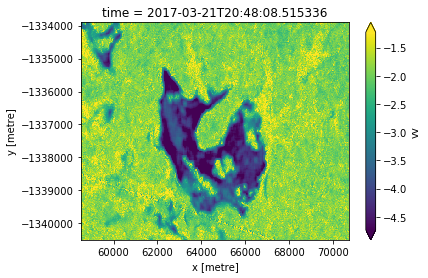

In [82]:
scene = logclean.isel(time = 30)
cscene = clean.isel(time=30)
dscene = logdirty.isel(time=30)
scene.vv.plot(robust=True)

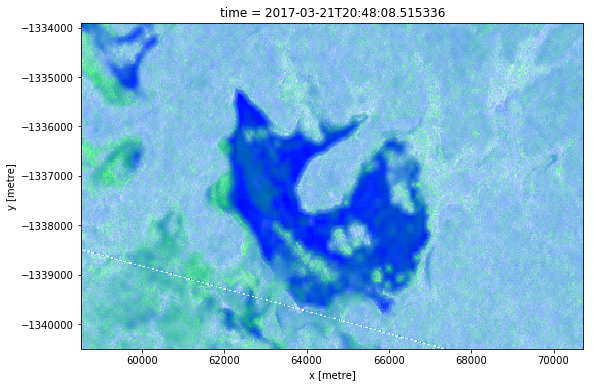

In [83]:
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting
DEAPlotting.rgb(scene, bands=['vh','vv','vh_over_vv'])

In [6]:
import skimage.segmentation as seg

In [84]:
nscene = scene

nscene['vv'] = (nscene['vv']-nscene['vv'].min())/(nscene['vv'].max()-nscene['vv'].min())
nscene['vh'] = (nscene['vh']-nscene['vh'].min())/(nscene['vh'].max()-nscene['vh'].min())
nscene['vh_over_vv'] = (nscene['vh_over_vv']-nscene['vh_over_vv'].min())/(nscene['vh_over_vv'].max()-nscene['vh_over_vv'].min())

sarray = nscene.to_array()

sarray = sarray.transpose('y','x','variable')
sarray = sarray.sortby('y',ascending=False)

sarray = sarray.fillna(0)

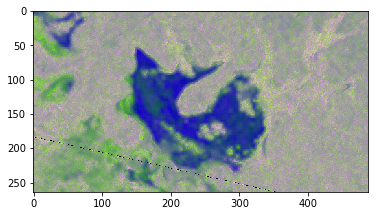

In [85]:
plt.imshow(sarray)

In [86]:
segmented = seg.quickshift(sarray)

In [73]:
import skimage.color as color

In [78]:
segmented.shape

(264, 488)

In [87]:
seg_img = color.label2rgb(segmented,sarray.values,kind='avg')

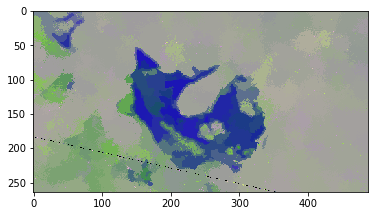

In [88]:
plt.imshow(seg_img)

In [89]:
np.unique(segmented).size

744